In [2]:
%matplotlib inline  


# Predicting New York City Taxi Fares: A DBSCAN and Random Forest Approach

### Dennis Murray - dmurray.ie99@gmail.com

## Introduction

The number of trips made annually in New York City taxis exceeds one hundred million per year.  For riders, and especially out of town riders, there is an element of the unknown when using a taxi because of the variability of the fare for each trip.

The fare for a trip consists of several components.  The base rate is charged each time a customer enters the cab.  After this is assessed, each 0.2 mile is assessed a rate, and each minute where the cab travels at less than 12 miles per hour is charged a surcharge.  Other surcharges exist for evening rush hour and overnight time periods.  In addition, several common trips - to the airports - hold their own fare structure.  Areas outside of the city also hold a different fare structure.

Thus, we will show that a simple linear function of distance times rate, plus base rate, will not produce an adequate estimate of the fare.  

Additional features will be required to help explain the local traffic patterns, or unique destinations like airports, that will create their own unique fare zones.

## Data Preparation and Import

In the interest of processing efficiency and understanding diminishing returns, a random sample of 1% of the trips was taken.  This still comprises more than 500,000 trips.

Basic New features were developed for:
1.  Difference In Latitude (Dropoff-pickup)
2.  Difference in Longitude (Dropoff-pickup)
3.  Euclidean Distance (Pythagorean Theorem length of the hypotenuse of Destination to Origin)
4.  Bearing of Travel, based on 0-360 degrees
5.  Year, Day of the Week, and Hour of the Day were developed from the Pickup date time

Any records with NA's for any field were dropped.  Records with difference of greater than 5 degrees of Longitude or Latitude were also dropped.  

The rationale for the added features is to attempt to capture some of the variation in fares during specific times of the day, and days of the week.  This variation could be either from the surcharge structure, or from the traffic conditions causing additional travel time under twelve miles per hour.

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import seaborn as sb
import numpy as np
from sklearn.metrics import mean_squared_error
from numpy import radians, cos, sin, arcsin, sqrt, arctan2, degrees

In [4]:
farehistory = pd.read_csv("data/train.csv")
farehistory = farehistory.sample(frac=0.01)

In [5]:
#feature development
farehistory['diffLong'] = abs(farehistory['dropoff_longitude'] - farehistory['pickup_longitude'])
farehistory['diffLat'] = abs(farehistory['dropoff_latitude'] - farehistory['pickup_latitude'])
#calculate as the crow flies distance without correction for globe
farehistory['euclidean'] = (farehistory['diffLong']**2 + farehistory['diffLat']**2)**0.5



In [6]:
#calculate heading of travel
farehistory['bearing'] = arctan2(sin(farehistory['dropoff_longitude'] - farehistory['pickup_longitude'])*cos(farehistory['dropoff_latitude']), cos(farehistory['pickup_latitude'])*sin(farehistory['dropoff_latitude'])-sin(farehistory['pickup_latitude'])*cos(farehistory['dropoff_latitude'])*cos(farehistory['dropoff_longitude'] -farehistory['pickup_longitude']))
farehistory['bearing'] = degrees(farehistory['bearing'])
farehistory['bearing'] = (farehistory['bearing'] + 360) % 360

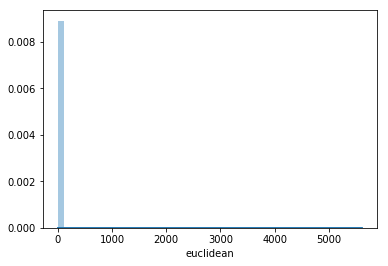

In [7]:
sb.distplot(farehistory['euclidean'].dropna())

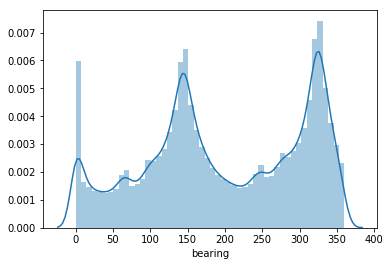

In [8]:
sb.distplot(farehistory['bearing'].dropna())

Most of the bearings of trips are either north bound, or southbound.  

In [9]:
farehistory = farehistory.dropna(how='any', axis='rows')
farehistory = farehistory[(farehistory['diffLong']<5.0) & (farehistory['diffLat']<5.0)]

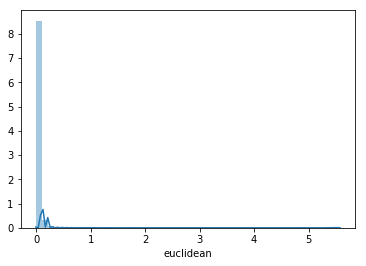

In [10]:
sb.distplot(farehistory['euclidean'].dropna())

In [11]:
farehistory['pickup_datetime']=pd.to_datetime(farehistory['pickup_datetime'])

In [12]:
farehistory.dtypes

key                          object
fare_amount                 float64
pickup_datetime      datetime64[ns]
pickup_longitude            float64
pickup_latitude             float64
dropoff_longitude           float64
dropoff_latitude            float64
passenger_count               int64
diffLong                    float64
diffLat                     float64
euclidean                   float64
bearing                     float64
dtype: object

In [13]:
#Decode day of the week and make into a one-hot categorical variable
farehistory['dayofweek'] = (farehistory['pickup_datetime'].dt.dayofweek)

#Decode hour of the day and make into a one-hot categorical variable
farehistory['hour'] = (farehistory['pickup_datetime'].dt.hour)
farehistory['year']= farehistory['pickup_datetime'].dt.year

   ## Base Models for Comparison: Linear Regression and Random Forest

As a point of comparison, using the basic features that have been developed, two general machine learing methods are applied:
1.  Linear Regression
2.  Random Forest

Throughout the process, we will use Root Mean Square Error as the measurement of error for the testing.  At all times, an 80/20 Train/Test split is used.

In [14]:
#convert day and hour to dummy variables


days = pd.get_dummies(farehistory['dayofweek'], prefix = "weekday")
hours  = pd.get_dummies(farehistory['hour'], prefix = "hour")
year = pd.get_dummies(farehistory['year'], prefix="year")

one_hot = pd.concat((days, hours, year), axis=1, join_axes=[days.index])

y = farehistory['fare_amount']
x = farehistory[['passenger_count', 'bearing', 'diffLat', 'diffLong', 'euclidean']]
x = pd.concat((x, one_hot), axis=1)

x.reset_index(drop=True,inplace=True)
#OriginDropOff.reset_index(drop=True,inplace=True)


#x = pd.concat((x, OriginDropOff), axis=1)
#x = farehistory.loc[:, 9:].values
x

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=1)

In [15]:
%time
from sklearn.linear_model import LinearRegression
linreg = LinearRegression()
linreg.fit(X_train, y_train)
print('Test Accuracy: %.3f' % linreg.score(X_test, y_test))


Wall time: 0 ns
Test Accuracy: 0.540


In [16]:
mean_squared_error(y_test,linreg.predict(X_test))**0.5

6.54624971978897

In [17]:
%%time
from sklearn.ensemble import RandomForestRegressor
rfr = RandomForestRegressor()

rfr.fit(X_train, y_train)
print('Test Accuracy: %.3f' % rfr.score(X_test, y_test))

Test Accuracy: 0.748
Wall time: 58 s


In [18]:
mean_squared_error(y_test,rfr.predict(X_test))**0.5

4.840015219393972

The model, with minimal features developed, has a RMSE of 6.54 for the linear model, and 4.84 for the Random Forest Regressor model.  

## Engineering New Feature: DBSCAN based Origins and Destinations

In the interest of providing information about common origins and destinations, we will cluster geographic points (either origins or destinations) using the DBSCAN algorithm.  The goal is to find common, high traffic areas that might have a large number of fares, and may experience some of the same traffic and congestion delays across trips within the same time and day of the week.

The "zones" will be established in a two-step process using a subset of the data that is otherwise being used to train the model, to avoid overwhelming available computing resources.  The cluster with the most points, excluding the "unclustered" condition, will be broken further in a second step to additional clusters.  Parameters were established via testing and choosing a balance between the size of clusters, and the number of clusters created.

Remaining points will be placed with the groups established through the DBSCAN process using a k-Nearest Neighbors algorithm.   

In [19]:
#create dbscan based clusters of "neighborhoods" for the origin and destination points

from sklearn.cluster import DBSCAN

points1 = farehistory[['pickup_latitude', 'pickup_longitude']]
points1 = points1.rename(columns={'pickup_latitude':"latitude", 'pickup_longitude':"longitude"})
points2 = farehistory[['dropoff_latitude', 'dropoff_longitude']]
points2 = points2.rename(columns={'dropoff_latitude':"latitude", 'dropoff_longitude':"longitude"})

all_points = pd.concat((points1, points2), axis=0)
all_points = all_points[(all_points['latitude']>=40) & (all_points['latitude']<=41)]
all_points = all_points[(all_points['longitude']<=-72) & (all_points['longitude']>=-75)]
plot_sample = all_points.sample(frac=0.01)

In [20]:
from sklearn.ensemble import RandomForestRegressor
rfr = RandomForestRegressor()

rfr.fit(X_train, y_train)
print('Test Accuracy: %.3f' % rfr.score(X_test, y_test))

Test Accuracy: 0.747


In [21]:
%%time
from sklearn.cluster import DBSCAN

params = []

subset = all_points.sample(frac=0.3, random_state=1, replace=False).reset_index(drop=True)

subsetscaled = StandardScaler().fit_transform(subset)

#Let's run with 0.075, 0.0001 as a starting point.  Seems to offer mix of detail and encompassing a lot of areas without too many clusters

minpts = 0.0002 * len(subset)
eps=0.07

dbscan = DBSCAN(eps=eps, min_samples = minpts)
dbscan.fit(X=subsetscaled)

newfeature  = dbscan.labels_
newfeature = pd.Series(newfeature)
newfeature = pd.DataFrame({'EPS': eps, 'MinPts'  :minpts, 'cluster': newfeature})
newfeature = pd.concat([subset, newfeature], axis=1)



Wall time: 33.1 s


In [22]:
%%time
#add a subclass for the largest clustering class which is Manhattan, class 0, try clustering at twice the density

eps = 0.049

subset = newfeature.loc[newfeature['cluster']==0]
subset = subset[['latitude', 'longitude']]

subsetscaled = StandardScaler().fit_transform(subset)


minpts = .0025 * len(subsetscaled)

subdbscan = DBSCAN(eps=eps, min_samples = minpts)
subdbscan.fit(X=subsetscaled)

newfeature2  = subdbscan.labels_
newfeature2 = pd.Series(newfeature2)
newfeature2 = pd.DataFrame({'EPS': eps, 'MinPts'  :minpts, 'cluster': newfeature2})
subset.reset_index(inplace=True, drop=True)
newfeature2 = pd.concat([subset, newfeature2], axis=1)


#len(newfeature2['cluster'].unique())
print(minpts)

733.04
Wall time: 10 s


In [23]:
len(newfeature2['cluster'].unique())

24

This configuration gives us more detailed clusters for about 1/6 of all of Manhattan points of interest.

In [24]:
newfeature = newfeature[newfeature['cluster']!=0]
newfeature.reset_index(inplace=True, drop=True)

In [25]:
highcluster = max(newfeature['cluster'])
newfeature2.loc[newfeature2.cluster==-1, ['cluster']] = 0
newfeature2.loc[newfeature2.cluster>0, ['cluster']] = newfeature2['cluster']+highcluster + 1


In [26]:
combined = pd.concat([newfeature, newfeature2], axis=0)
newfeature = combined

In [27]:
%%time
#train a model to classify other examples of lat, long to known cluster
Y = (newfeature['cluster'])
X = pd.DataFrame(newfeature[['latitude', 'longitude']])

from sklearn import linear_model
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

from sklearn.ensemble import RandomForestRegressor
rfr = RandomForestRegressor()

from sklearn.neighbors import KNeighborsClassifier

#logreg = linear_model.LogisticRegression()

X_train, X_test, y_train, y_test = \
    train_test_split(X, Y, test_size=0.30, random_state=1)
    
kfold = StratifiedKFold(5,random_state=1).split(X_train, y_train)

#logreg.fit(X, Y)

pipe_lr = Pipeline([('scl', StandardScaler()),
                    ('knn', KNeighborsClassifier(n_neighbors=10))])

pipe_lr.fit(X_train, y_train)
score = pipe_lr.score(X_test, y_test)

scores = []
#for k, (train, test) in enumerate(kfold):
#    pipe_lr.fit(X_train[train], y_train[train])
#    score = pipe_lr.score(X_train[test], y_train[test])
#    scores.append(score)
#    print('Fold: %s, Class dist.: %s, Acc: %.3f' % (k + 1,
#          np.bincount(y_train[train]), score))

#print('\nCV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))


Wall time: 1.05 s


In [28]:
Predictions=pd.DataFrame({'predict':pipe_lr.predict(X_test), 'actual':y_test})

Many of the mismatches are cluster -1 (unclassified) and they've been classified into other groups.  Overall it's ~2,700 rows of more than 300,000 examples, so it's probably a fairly good classification.

## Training a New Model Using Origin and Destination Clusters

Combining our newly introduced origin and destination clusters, added to the previously build features - we will now refit a Random Forest Regressor to predict taxifares for city wide data, again using a 70/30 test/train split.

In [29]:
Origins = farehistory[['pickup_latitude', 'pickup_longitude']]
OriginGroup = pipe_lr.predict(Origins)

Dropoffs = farehistory[['dropoff_latitude', 'dropoff_longitude']]
DropoffGroup = pipe_lr.predict(Dropoffs)


In [30]:
OriginGroup = pd.get_dummies(OriginGroup, prefix="origin")
DropoffGroup = pd.get_dummies(DropoffGroup, prefix="destination")
OriginDropOff = pd.concat((OriginGroup, DropoffGroup), axis=1, join_axes=[OriginGroup.index])

In [31]:
#convert day and hour to dummy variables


days = pd.get_dummies(farehistory['dayofweek'], prefix = "weekday")
hours  = pd.get_dummies(farehistory['hour'], prefix = "hour")
year = pd.get_dummies(farehistory['year'], prefix="year")

one_hot = pd.concat((days, hours, year), axis=1, join_axes=[days.index])

In [32]:
y = farehistory['fare_amount']
x = farehistory[['passenger_count', 'bearing', 'diffLat', 'diffLong']]
x = pd.concat((x, one_hot), axis=1)

x.reset_index(drop=True,inplace=True)
OriginDropOff.reset_index(drop=True,inplace=True)


x = pd.concat((x, OriginDropOff), axis=1)
#x = farehistory.loc[:, 9:].values

In [33]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=1)

In [34]:
from sklearn.ensemble import RandomForestRegressor
rfr = RandomForestRegressor()

rfr.fit(X_train, y_train)
print('Test Accuracy: %.3f' % rfr.score(X_test, y_test))

Test Accuracy: 0.759


In [35]:
mean_squared_error(y_test,rfr.predict(X_test))**0.5

4.734241913535596

In [36]:
predicted = rfr.predict(X_test)
predicted = pd.DataFrame(predicted, columns=['predicted'])

In [37]:
X_test.reset_index(inplace=True, drop=True)

In [38]:
tested = pd.DataFrame(y_test.reset_index(drop=True))
completetest = pd.concat((tested, predicted, X_test), axis=1)
#pd.concat((predicted, pd.Series(y_test.reset_index(drop=True))), axis=1)

In [39]:
UnclusteredOriginScore  = completetest.loc[(completetest['origin_-1']==0) & (completetest['destination_-1']==0)]
(mean_squared_error(UnclusteredOriginScore['fare_amount'],UnclusteredOriginScore['predicted']))**0.5

3.4479178917827737

In [40]:
KnownOrigin  = completetest.loc[completetest['origin_-1']!=1]
mean_squared_error(KnownOrigin['fare_amount'],KnownOrigin['predicted'])**0.5

3.787849228927795

While the general model performs no better than the previous model without the origin/destination clusters, when we exclude trips that had an "unclustered" origin or destination, the remainder of trips has a RMSE of 3.45 for trips with both origin and destination fitting a known cluster.

With only a known origin, the error still improves to 3.78.

### Conclusions and Next Steps

While the clustering solution failed to provide a better solution for *all* data points, it did provide a better solution for trips involving known origins and destinations.  

Increasing the number of clusters could help address the number of trips falling entirely into a single clusters, like regions of Manhattan.  

Use of a deepl learning algorithm would likely create a more accurate model, with the ability to address more granualarity of origin and destination.  Use of additional data for more training would also have an impact in such a model.

### Appendix - Prediction for New Data Set 

The remainder of code will address creating a data set for a Kaggle submission, based on the test data set of origins, destinations, and pick up times.

In [41]:
newTest = pd.read_csv("data/test.csv")

In [42]:
#feature development
newTest['diffLong'] = abs(newTest['dropoff_longitude'] - newTest['pickup_longitude'])
newTest['diffLat'] = abs(newTest['dropoff_latitude'] - newTest['pickup_latitude'])
#calculate as the crow flies distance without correction for globe
newTest['euclidean'] = (newTest['diffLong']**2 + newTest['diffLat']**2)**0.5

#Sets of all values for hours, days, years, origin, dropoff

dayset = list(range(0,7))
hourset = list(range(0,24))
yearset = list(range(2009,2016))
geographies = list(range(-1,45))
geographies.remove(23)
geographies.remove(26)


#calculate heading of travel
newTest['bearing'] = arctan2(sin(newTest['dropoff_longitude'] - newTest['pickup_longitude'])*cos(newTest['dropoff_latitude']), cos(newTest['pickup_latitude'])*sin(newTest['dropoff_latitude'])-sin(newTest['pickup_latitude'])*cos(newTest['dropoff_latitude'])*cos(newTest['dropoff_longitude'] -newTest['pickup_longitude']))
newTest['bearing'] = degrees(newTest['bearing'])
newTest['bearing'] = (newTest['bearing'] + 360) % 360

Origins = newTest[['pickup_latitude', 'pickup_longitude']]
OriginGroup = pipe_lr.predict(Origins)

Destinations = newTest[['pickup_latitude', 'pickup_longitude']]
DropoffGroup = pipe_lr.predict(Destinations)


newTest['pickup_datetime']=pd.to_datetime(newTest['pickup_datetime'])

#Decode day of the week and make into a one-hot categorical variable
newTest['dayofweek'] = (newTest['pickup_datetime'].dt.dayofweek)

#Decode hour of the day and make into a one-hot categorical variable
newTest['hour'] = (newTest['pickup_datetime'].dt.hour)
newTest['year']= newTest['pickup_datetime'].dt.year


days = pd.get_dummies(newTest['dayofweek'], prefix = "weekday")
hours  = pd.get_dummies(newTest['hour'], prefix = "hour")
year = pd.get_dummies(newTest['year'], prefix="year")

one_hot = pd.concat((days, hours, year), axis=1, join_axes=[days.index])

OriginGroup = pd.get_dummies(OriginGroup, prefix="origin")
OriginGroup = OriginGroup.T.reindex(geographies).T.fillna(0)
DropoffGroup = pd.get_dummies(DropoffGroup, prefix="destination")
DropoffGroup = DropoffGroup.T.reindex(geographies).T.fillna(0)

OriginDropOff = pd.concat((OriginGroup, DropoffGroup), axis=1, join_axes=[OriginGroup.index])

newX = newTest[['passenger_count', 'bearing', 'diffLat', 'diffLong']]
newX = pd.concat((newX, one_hot), axis=1)

newX.reset_index(drop=True,inplace=True)
OriginDropOff.reset_index(drop=True,inplace=True)


newX = pd.concat((newX, OriginDropOff), axis=1)
#x = farehistory.loc[:, 9:].values
newX.reset_index(drop=True, inplace=True)


In [43]:
newpredict = rfr.predict(newX)

ValueError: Number of features of the model must match the input. Model n_features is 138 and input n_features is 130 

In [ ]:
newpredict = pd.DataFrame({'key':newTest['key'], 'fare_amount':newpredict})

In [ ]:
newpredict = newpredict[['key', 'fare_amount']]
newpredict.to_csv("dpmurraypredict.csv", index=False)

In [ ]:
from sklearn.linear_model import LinearRegression
linreg = LinearRegression()

linreg.fit(X_train, y_train)
print('Test Accuracy: %.3f' % linreg.score(X_test, y_test))

In [ ]:
mean_squared_error(y_test,linreg.predict(X_test))**0.5

In [ ]:
from sklearn.ensemble import AdaBoostRegressor
abr = AdaBoostRegressor()

abr.fit(X_train, y_train)
print('Test Accuracy: %.3f' % abr.score(X_test, y_test))

In [ ]:
mean_squared_error(y_test,abr.predict(X_test))**0.5

In [ ]:
from sklearn.linear_model import BayesianRidge
brm = BayesianRidge()

brm.fit(X_train, y_train)

print('Test Accuracy: %.3f' % brm.score(X_test, y_test))


In [ ]:
mean_squared_error(y_test,brm.predict(X_test))**0.5